In [1]:
# This cell changes display settings for the notebook.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import train_models
from PIL import Image, ImageFilter
from misc_functions import (
    get_example_params, convert_to_grayscale, save_gradient_images, preprocess_image
    )
from vanilla_backprop import VanillaBackprop 
from gradcam import GradCam


In [3]:
# Visualization for gradient class activation map using vanilla backprop
def grad_cam(train,dataset,dp,example_index):
    pretrained_model,classes,trainloader,testloader,trainset,testset = train_models.get_trained_model(train,dataset,dp)
    
    for param in pretrained_model.parameters():
        param.requires_grad = False 

    f, axarr = plt.subplots(1,2) 
    f.set_figheight(7)
    f.set_figwidth(7)

    print('model loaded, forwarding examples')

    dataiter = iter(testloader)
    images, labels = dataiter.next()

    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    denormalized_image = images[example_index] * torch.tensor(std).view(3, 1, 1)
    denormalized_image = denormalized_image + torch.tensor(mean).view(3, 1, 1)
    
    original_image = transforms.ToPILImage(mode='RGB')(denormalized_image)
    prep_img = preprocess_image(original_image,True)
    grad_cam = GradCam(pretrained_model, target_layer=11)
    
    yhat = pretrained_model.forward(images.cuda())
    target_class = np.argmax(yhat[example_index].data.cpu().numpy())
    
    cam = grad_cam.generate_cam(prep_img, target_class)
    print(f'\nPredicted Class: {classes[target_class]}')

    axarr[0].imshow(original_image)
    axarr[0].title.set_text(f'Original Image - ')
    axarr[1].imshow(cam)
    axarr[1].title.set_text(f'Gradient CAM Wo/DP-')
    
    plt.show()    

def test_model_accuracy(dataset,dp):
    model,classes,trainloader,testloader,trainset,testset = train_models.get_trained_model(dataset,dp)
    print('model loaded, testing test set')

    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.cuda()).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
                correct+=c[i].item()
                total+=1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i],100 * class_correct[i] / class_total[i]))
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# Visualization for class saliency map using vanilla backprop
def vanilla_backprop_saliency(dataset,dp,example_index):
    model,classes,trainloader,testloader,trainset,testset = train_models.get_trained_model(dataset,dp)
    
    f, axarr = plt.subplots(1,2) 
    f.set_figheight(7)
    f.set_figwidth(7)
    VBP = VanillaBackprop(model)

    print('model loaded, forwarding examples')
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    denormalized_image = images[example_index] * torch.tensor(std).view(3, 1, 1)
    denormalized_image = denormalized_image + torch.tensor(mean).view(3, 1, 1)
    original_image = transforms.ToPILImage(mode='RGB')(denormalized_image)
    prep_img = preprocess_image(original_image,True)
    vanilla_grads = VBP.generate_gradients(prep_img)
    grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
    
    yhat = model.forward(images.cuda())
    target_class = np.argmax(yhat[example_index].data.cpu().numpy())
    print(f'\nPredicted Class: {classes[target_class]}')

    axarr[0].imshow(original_image)
    axarr[0].title.set_text(f'Original Image - ')
    axarr[1].imshow(grayscale_vanilla_grads.squeeze(0))
    axarr[1].title.set_text(f'Gradient Visualization Vanilla Backprop Wo/DP-')
    
    plt.show()    




using dataset:      mnist
Model valid:        True
Model trained DP:   False
model loaded, testing test set
Accuracy of  zero : 91 %
Accuracy of   one : 98 %
Accuracy of   two : 98 %
Accuracy of three : 95 %
Accuracy of  four : 90 %
Accuracy of  five : 93 %
Accuracy of   six : 95 %
Accuracy of seven : 98 %
Accuracy of eight : 98 %
Accuracy of  nine : 97 %
Accuracy of the network on the 10000 test images: 95 %
using dataset:      mnist
Model valid:        True
Model trained DP:   False
model loaded, forwarding examples

Predicted Class: seven


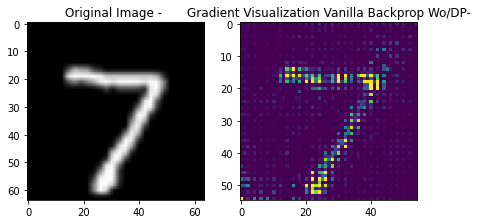

using dataset:      mnist
Model valid:        True
Model trained DP:   True
model loaded, testing test set
Accuracy of  zero : 86 %
Accuracy of   one : 94 %
Accuracy of   two : 78 %
Accuracy of three : 77 %
Accuracy of  four : 78 %
Accuracy of  five : 69 %
Accuracy of   six : 80 %
Accuracy of seven : 81 %
Accuracy of eight : 65 %
Accuracy of  nine : 75 %
Accuracy of the network on the 10000 test images: 79 %
using dataset:      mnist
Model valid:        True
Model trained DP:   True
model loaded, forwarding examples

Predicted Class: seven


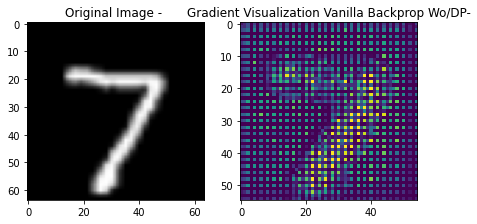

In [4]:



dataset        = 'mnist'  # not being used currently
dp             = False
example_index  = 0

test_model_accuracy(dataset,dp)
vanilla_backprop_saliency(dataset,dp,example_index)
# grad_cam(train,dataset,dp,example_index) 


dataset        = 'mnist'  # not being used currently
dp             = True
example_index  = 0

test_model_accuracy(dataset,dp)
vanilla_backprop_saliency(dataset,dp,example_index)
# grad_cam(train,dataset,dp,example_index) 

pass